# Pipeline

In [1]:
# Imports

import torch

import networkx as nx

import numpy as np
import pandas as pd
import scipy.io
 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import pickle

from tensorly.decomposition import tucker, constrained_parafac

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import IsolationForest

### Load Network & Ego Nets

In [2]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [3]:
G, ego_gs, roots = load_network(input('Enter dataset path: '))

roots = [int(r) for r in roots]

Enter dataset path: datasets/BlogCatalog.mat
Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

In [4]:
print(f'Using {len(ego_gs)} egonets')

Using 5196 egonets


### Generate Tensor

### Separate Anomalies

In [6]:
# 1: anomalous egonet ==> anomalous root
# 2: anomalous egonet ==> any anomalous node

print('1: anomalous egonet ==> anomalous root')
print('2: anomalous egonet ==> any anomalous node')

anom_def = int(input('Anomalous definition: '))

1: anomalous egonet ==> anomalous root
2: anomalous egonet ==> any anomalous node
Anomalous definition: 2


In [7]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [8]:
anom_gs, clean_gs = [], []
if anom_def == 1:
    for idx, root_attr in enumerate(tqdm(roots)):
        if root_attr == 1:
            anom_gs.append(ego_gs[idx])
        else:
            clean_gs.append(ego_gs[idx])
elif anom_def == 2:
    for idx, g in enumerate(tqdm(ego_gs)):
        # check if root is anomolous first
        if is_anomolous(g):
            anom_gs.append(g)
        else:
            clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [9]:
slice_size = int(input("Input a slice size for tensor: "))

cube = torch.empty((1, slice_size, slice_size, slice_size))

for i in tqdm(range(len(clean_gs[:slice_size]))):
    slice_gs = nx.to_numpy_array(clean_gs[i])[:slice_size, :slice_size]
    result = np.zeros((slice_size, slice_size))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

Input a slice size for tensor: 1000


  0%|          | 0/476 [00:00<?, ?it/s]

In [10]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [11]:
anom_y = np.zeros(len(anom_gs))
clean_y = np.zeros(len(clean_gs))

### Tensor Decomposition + Reconstruction Error

In [12]:
ranks = [int(r) for r in input('Enter ranks, space separated: ').split()]

Enter ranks, space separated: 50


Load previous decomposition? (y/n): y
Enter file path: bc_cpd_r50.sav
Enter clustering method (1) Isolation Forest or (2) K-Means: 2


  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

(array([0, 1]), array([ 476, 4720]))
(array([0, 1], dtype=int32), array([3848, 1348]))
              precision    recall  f1-score   support

           0       0.12      1.00      0.22       476
           1       1.00      0.29      0.44      4720

    accuracy                           0.35      5196
   macro avg       0.56      0.64      0.33      5196
weighted avg       0.92      0.35      0.42      5196



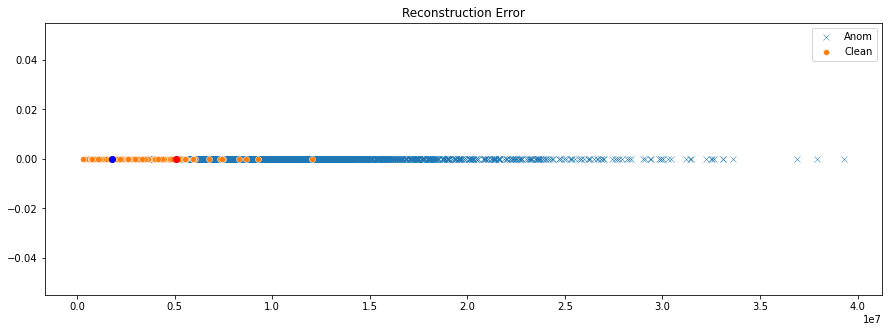

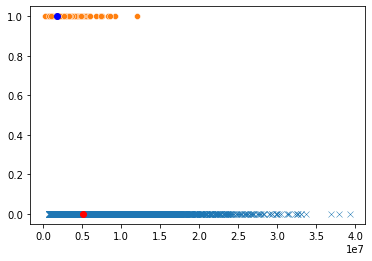

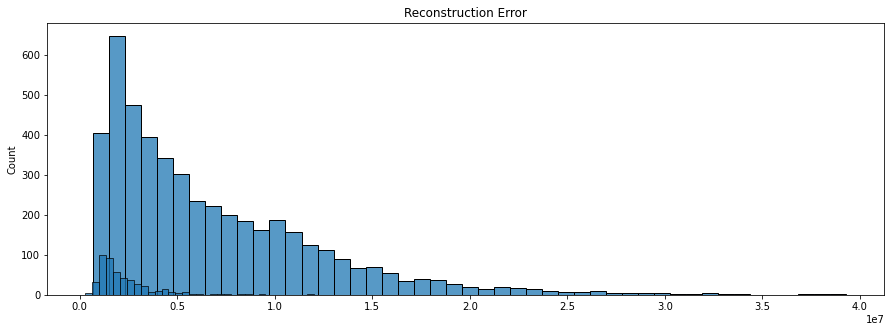

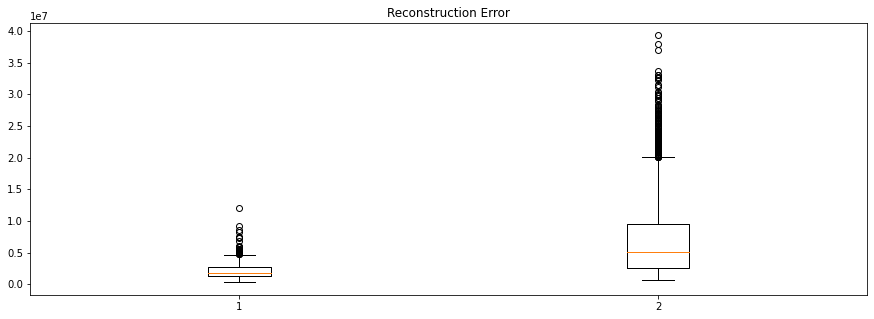

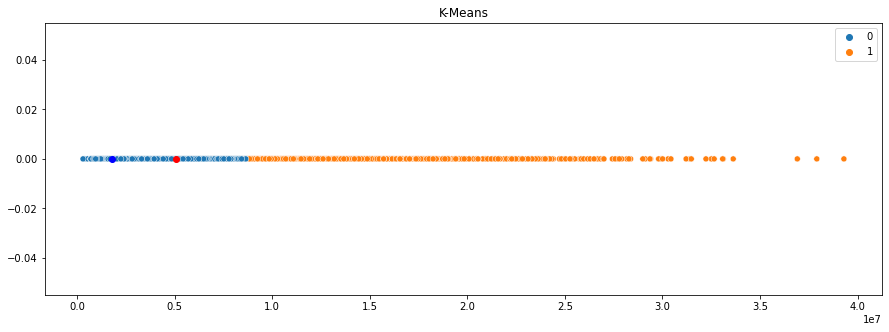

In [13]:
for rank in ranks:
    load = input('Load previous decomposition? (y/n): ')
    if load.lower()[0] == 'n':
        print(f'USING RANK {rank}\n')
        path = input('Enter file name to save as: ') + '.sav'
        decomp = input('Select Tucker (1) or CP (2) decomposition: ')
        if decomp == '1':
            core, factors = tucker(cube[0].numpy(), rank=rank)
        elif decomp == '2':
            weights, factors = constrained_parafac(cube[0].numpy(), rank=rank)
        saved_model = open(path, 'wb')
        pickle.dump(factors, saved_model)
        saved_model.close()
    else:
        with open(input('Enter file path: '), 'rb') as f:
            factors = pickle.load(f)
            f.close()
    
    clus_method = input('Enter clustering method (1) Isolation Forest or (2) K-Means: ')
    
    A, B, C = factors
    A, B, C, = np.array(A), np.array(B), np.array(C)
    
    results_anom = []
    for gs in tqdm(padded_anom):
        gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
        d = np.linalg.norm(gs - gs_p)
        results_anom.append(d)
        
    results_clean = []
    for gs in tqdm(padded_clean):
        gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
        d = np.linalg.norm(gs - gs_p)
        results_clean.append(d)
        
    ## PLOTS
    
    plt.figure(figsize=(15,5))
    plt.title('Reconstruction Error')
    if len(anom_y) > len(clean_y):
        sns.scatterplot(x=results_anom, y=anom_y, marker='x')
        sns.scatterplot(x=results_clean, y=clean_y, marker='o')
        plt.scatter([np.median(results_anom)], 0, c='red')
        plt.scatter([np.median(results_clean)], 0, c='blue')
    else:
        sns.scatterplot(x=results_clean, y=clean_y, marker='o')  
        sns.scatterplot(x=results_anom, y=anom_y, marker='x')
        plt.scatter([np.median(results_anom)], 0, c='red')
        plt.scatter([np.median(results_clean)], 0, c='blue')

    plt.legend(['Anom', 'Clean'])
    
    plt.figure()
    sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
    sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
    plt.scatter([np.median(results_anom)], 0, c='red')
    plt.scatter([np.median(results_clean)], 1, c='blue')
    
    plt.figure(figsize=(15,5))
    plt.title('Reconstruction Error')
    sns.histplot(results_anom)
    sns.histplot(results_clean, ax=plt.gca())
    
    plt.figure(figsize=(15,5))
    plt.title('Reconstruction Error')
    comb = [results_clean, results_anom]
    plt.boxplot(comb)
    
    
    ## KMEANS - 2 clusters
    
    results, true_labels = [], []
    results.extend(results_clean); results.extend(results_anom)
    true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))
    
    results = np.array(results).reshape(-1, 1)
        
    if clus_method == '1':
        ifor = IsolationForest()
        pred = ifor.fit_predict(results)
        labels = [1 if p == -1 else 0 for p in pred]
        plt.title('IF Clustering')
        sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
        plt.scatter([np.median(results_anom)], 0, c='red')
        plt.scatter([np.median(results_clean)], 0, c='blue')
    elif clus_method == '2':
        plt.figure(figsize=(15,5))
        plt.title('K-Means')
        kmeans = KMeans(n_clusters=2, random_state=1).fit(results)
        sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)
        plt.scatter([np.median(results_anom)], 0, c='red')
        plt.scatter([np.median(results_clean)], 0, c='blue')
        labels = kmeans.labels_
    
    print(np.unique(true_labels, return_counts=True))
    print(np.unique(labels, return_counts=True))

    print(classification_report(true_labels, labels))